In [1]:
!XLA_FLAGS=--xla_gpu_cuda_data_dir=/cm/shared/sw/pkg/devel/cuda/10.1.243_418.87.00

In [2]:
import jax
print("jax version: ", jax.__version__)
import jax.numpy as np
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz

rng = jax.random.PRNGKey(2)

jax version:  0.2.10


In [3]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [4]:
# for model stuff
import jax.experimental.optimizers as optimizers
import jax.experimental.stax as stax
from jax import jit

# for imnn
import imnn
print("IMNN version: ", imnn.__version__)

from imnn.imnn import (
    AggregatedGradientIMNN,
    AggregatedNumericalGradientIMNN,
    AggregatedSimulatorIMNN,
    GradientIMNN,
    NumericalGradientIMNN,
    SimulatorIMNN,
)
from imnn.lfi import (
    ApproximateBayesianComputation,
    GaussianApproximation,
)
from imnn.utils import value_and_jacrev, value_and_jacfwd

rng = jax.random.PRNGKey(0)

IMNN version:  0.3dev


In [5]:
N = 20

In [6]:
def scipy_compute_r2(N):
    _Di = np.tile(toeplitz(np.arange(N)), (N, N))
    _Dj = np.concatenate(
        [np.concatenate(
            [np.tile(np.abs(i - j),(N, N)) 
             for i in range(N)], 
            axis=0)
         for j in range(N)],
        axis=1)
    _distance_squared = _Di * _Di + _Dj * _Dj
    return _distance_squared

def compute_r2(N):
    _r2 = np.tile(np.abs(np.expand_dims(np.arange(N), 0) 
                    - np.expand_dims(np.arange(N), 1)), (N, N)) ** 2. + np.abs(np.expand_dims(np.repeat(np.arange(N), N), 0) 
                             - np.expand_dims(np.repeat(np.arange(N), N), 1)) ** 2.
    return _r2

r2 = compute_r2(N).astype(np.float32)

def ξ_G(β):
    return np.exp(
        -np.expand_dims(r2, tuple(np.arange(β.ndim))) 
        / 4. / np.expand_dims(β, (-2, -1))**2.)

def get_G_field(β):
    pass

def fill_zeros(k, value):
    from functools import partial

    def fnk(k):
        return jax.lax.cond(np.less_equal(k, 1e-5), lambda _: value, lambda k: k+value, operand=k)

    if len(k.shape) == 1:
        return jax.vmap(fnk)(k)
    else:
        return jax.vmap(partial(fill_zeros, value=value))(k)


def xi_LN(r, α, β, PixelNoise=0.01):

    xi = 1/(np.power(α+1e-12,2)) * (np.exp(np.power(α,2)*np.exp(-0.25*np.power(r/β,2))) - 1)

    # Add pixel noise at zero separation:

    xi = fill_zeros(xi, PixelNoise**2)
    #xi[np.where(r<1e-5)] += PixelNoise**2

    return xi

In [7]:
def dxi_LN_dalpha(r, α, β):

    _deriv =  2/(α+1e-12) * np.exp(-0.25*np.power(r/β,2)) * np.exp(np.power(α,2)*np.exp(-0.25*np.power(r/β,2))) - 2/np.power(α+1e-12,3) * (np.exp(np.power(α,2)*np.exp(-0.25*np.power(r/β,2))) - 1)
    return _deriv

def dxi_LN_dbeta(r, β, α):

    return (0.5*np.power(r, 2) * np.exp(np.power(α, 2) * np.exp(-0.25 * np.power(r/β,2)) - 0.25*np.power(r/β,2)))*np.power(1./β,3)
    #return (-0.5*r/np.power(β,2)) * np.exp(-0.25*np.power(r/β,2)) * np.exp(np.power(α,2)*np.exp(-0.25*np.power(r/β,2)))

In [8]:
def simulator(rng, n, 
        α, β, μ=np.zeros((N**2,), dtype=np.float32), 
        σ=np.ones((N**2 * (N**2 + 1) // 2,), dtype=np.float32)):
    dist = tfd.TransformedDistribution(
        #distribution=tfd.TransformedDistribution(
            distribution=tfd.MultivariateNormalTriL(
                loc=μ, 
                scale_tril=tfp.math.fill_triangular(σ) 
                    * np.linalg.cholesky(ξ_G(β))),
            #bijector=tfb.Reshape((N, N))),
              bijector=tfb.Chain([
                    tfb.Scale(np.float32(1.) / np.expand_dims(α, (-1))),
                    tfb.Expm1(),
                    tfb.AffineScalar(shift=-np.float32(0.5) * np.expand_dims(α, -1)**np.float32(2.), scale=np.expand_dims(α, -1))]))
    if n is not None:
        return dist.sample(n, seed=rng)
    else: 
        return dist.sample(seed=rng)

In [9]:
def _f_NL(
        _α, _β, 
        μ=np.zeros((N**2,), dtype=np.float32), 
        σ=np.ones((N**2 * (N**2 + 1) // 2,), dtype=np.float32)):
    return tfd.JointDistributionNamed(
        dict(
            α = tfd.Uniform(low=np.float32(0.), high=np.float32(2.)),
            β = tfd.Uniform(low=np.float32(0.2), high=np.float32(0.8)),
            f_NL = tfd.TransformedDistribution(
                #distribution=tfd.TransformedDistribution(
                    distribution=tfd.MultivariateNormalTriL(
                        loc=μ, 
                        scale_tril=tfp.math.fill_triangular(σ) 
                            * np.linalg.cholesky(ξ_G(_β))),
                    #bijector=tfb.Reshape((N, N))),
                bijector=tfb.Chain([
                    tfb.Scale(np.float32(1.) / np.expand_dims(_α, (-1))),
                    tfb.Expm1(),
                    tfb.AffineScalar(shift=-np.float32(0.5) * np.expand_dims(_α, -1)**np.float32(2.), scale=np.expand_dims(_α, -1))]))))

In [10]:
f_NL = tfd.JointDistributionNamed(
    dict(
        α = tfd.Uniform(low=np.float32(0.), high=np.float32(2.)),
        β = tfd.Uniform(low=np.float32(0.2), high=np.float32(0.8)),
        μ = tfd.Normal(
            loc=np.zeros((N**2,), dtype=np.float32), 
            scale=np.ones((N**2,), dtype=np.float32)),                 
        σ = tfp.distributions.Uniform(
            low=np.zeros((N**2 * (N**2 + 1) // 2,), dtype=np.float32), 
            high=np.ones((N**2 * (N**2 + 1) // 2,), dtype=np.float32)),
        f_NL = lambda α, β, μ, σ: tfd.TransformedDistribution(
            #distribution=tfd.TransformedDistribution(
                distribution=tfd.MultivariateNormalTriL(
                    loc=μ, 
                    scale_tril=tfp.math.fill_triangular(σ) 
                        * np.linalg.cholesky(ξ_G(β))),
        bijector=tfb.Chain([
                    tfb.Scale(np.float32(1.) / np.expand_dims(α, (-1))),
                    tfb.Expm1(),
                    tfb.AffineScalar(shift=-np.float32(0.5) * np.expand_dims(α, -1)**np.float32(2.), scale=np.expand_dims(α, -1))]))))

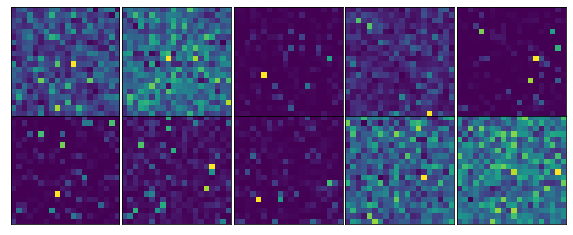

In [11]:
rng, key = jax.random.split(rng)
f_NLs = f_NL.sample(10, seed=key)["f_NL"].reshape((10, N, N))
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(2):
    for j in range(5):
        a = ax[i, j].imshow(f_NLs[j + i * 5])
        ax[i, j].set(xticks=[], yticks=[])
#plt.colorbar(a)

In [73]:
key,rng = jax.random.split(rng)

_a,_b = [np.ones(20)*1.0, np.ones(20)*(0.5)]
#plt.imshow(_f_NL(_a, _b).sample(seed=key)['f_NL'].reshape(N,N))

In [74]:
vals = _f_NL(_a, _b).sample(seed=key)['f_NL']

trgs = {'α': _a, 'β': _b, 'f_NL': vals}

In [101]:
vals = _f_NL(np.array(1.0), np.array(0.5)).sample(20, seed=key)['f_NL']

In [102]:
vals.shape

(20, 400)

In [76]:
def _get_f_NL_for_grad(θ, my_f_NL):
    _α, _β = θ
    # take in _α,_β, f_NL, and build dict to pass to _f_NL
    _dct = {
        'α': _α,
        'β': _β,
        'f_NL': my_f_NL
    }
    return _f_NL(_α, _β).log_prob(_dct)

In [15]:
agrd, bgrd = (jax.vmap(jax.grad(_get_f_NL_for_grad, argnums=[0,1])))(_a,_b,vals)


In [17]:
np.var(agrd)

DeviceArray(12207.2705, dtype=float32)

In [18]:
np.var(bgrd)

DeviceArray(5315.4062, dtype=float32)

In [16]:
from jax import jacfwd, jacrev

In [77]:
blah = jax.jacrev(jax.jacfwd(_get_f_NL_for_grad, argnums=[0,1]))(_a,_b,vals)

TypeError: _get_f_NL_for_grad() takes 2 positional arguments but 3 were given

In [78]:
hessian_loglik = jax.jit(jax.hessian(_get_f_NL_for_grad, argnums=[0]))

In [94]:
np.array([hessian_loglik(np.array([1.0, 0.5]), my_f_NL=vals[i]) for i in range(20)]).shape

(20, 1, 1, 2, 2)

In [95]:
F = np.mean(np.squeeze(np.array([hessian_loglik(np.array([1.0, 0.5]), my_f_NL=vals[i]) for i in range(20)])), axis=0)

In [96]:
F

DeviceArray([[-10772.115 ,  -2020.0813],
             [ -2020.081 ,  -5725.5337]], dtype=float32)

In [97]:
np.linalg.det(F)

DeviceArray(57595428., dtype=float32)

In [98]:
F * (1. / (0.8 - 0.2)) * (0.5)

DeviceArray([[-8976.763 , -1683.401 ],
             [-1683.4009, -4771.278 ]], dtype=float32)